# **Final Assignment - Semantic Segmentation**

Objective: Implement and evaluate two CNNs for Semantic Segmentation

Dataset: ISPRS 2D Semantic Labeling Challenge (Vaihingen)

<figure>
<center>
<img src= 'https://drive.google.com/uc?export=view&id=19wmyEXtnTV8gMOn02FPeJ8JcVSKVOycH'/>
</figure>

In the code below the network was trained only with image Train1.

In the assignment you should use both Train1 and Train2 images to train.

Notice that you will have to adapt the so that the network will take as imput an image concatenated with its DSM.




# **1. Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr, gdal

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Dropout, concatenate, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **2. Defining root folder**

In [ ]:
# root_path will be used to store trained models

from google.colab import drive
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# adjust the path to the location where the models will be written / read
root_path = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


# **3. Loading the data**

In [ ]:
# Downloading the dataset and unpacking it.
# 6 files: Test_Image.tif, Test_DSM.tif, Test_Reference.tif, Train1_Image.tif, Train1_DSM.tif, Train1_Reference.tif, Train2_Image.tif, Train2_DSM.tif, Train2_Reference.tif

!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part2.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part3.rar
!unrar e Images_Semantic_Segmentatio_Assignment.part1.rar


--2023-07-18 00:31:43--  https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar [following]
--2023-07-18 00:31:43--  https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25165824 (24M) [application/octet-stream]
Saving to: ‘Images_Semantic_Segmentatio_Assignment.part1.rar’

Images_Semantic_Seg 100%[===================>]  24.00M  --.-KB/

In [ ]:
# Listing the contents of the virtual machine.
!ls -l

total 226224
drwx------ 5 root root     4096 Jul 18 00:31 drive
-rw-r--r-- 1 root root 25165824 Jul 18 00:31 Images_Semantic_Segmentatio_Assignment.part1.rar
-rw-r--r-- 1 root root 25165824 Jul 18 00:31 Images_Semantic_Segmentatio_Assignment.part2.rar
-rw-r--r-- 1 root root  9414015 Jul 18 00:31 Images_Semantic_Segmentatio_Assignment.part3.rar
drwxr-xr-x 1 root root     4096 Jul 14 13:31 sample_data
-rw-r--r-- 1 root root 28852100 Aug 19  2014 Test_DSM.tif
-rw-r--r-- 1 root root 21789756 Nov  1  2013 Test_Image.tif
-rw-r--r-- 1 root root 22326104 Apr 28  2014 Test_Reference.tif
-rw-r--r-- 1 root root 19707152 Aug 19  2014 Train1_DSM.tif
-rw-r--r-- 1 root root 14870332 Nov  1  2013 Train1_Image.tif
-rw-r--r-- 1 root root 15259952 Apr 28  2014 Train1_Reference.tif
-rw-r--r-- 1 root root 19398356 Aug 19  2014 Train2_DSM.tif
-rw-r--r-- 1 root root 14643100 Nov  1  2013 Train2_Image.tif
-rw-r--r-- 1 root root 15036852 Apr 28  2014 Train2_Reference.tif


In [ ]:
# Functions

def load_tiff_image(image):
  print (image)
  gdal_header = gdal.Open(image)
  img_gdal = gdal_header.ReadAsArray()
  img = np.transpose(img_gdal, (1,2,0))
  return img

def load_tiff_dsm(image):
  print (image)
  gdal_header = gdal.Open(image)
  img = gdal_header.ReadAsArray()
  return img



def normalization(image):
  if len(image.shape) == 2:  # Single-channel image
    image_reshaped = image.reshape((image.shape[0] * image.shape[1], 1))
  else:  # Multi-channel image
    image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)

  if len(image.shape) == 2:  # Single-channel image
    image_normalized = image_normalized_.reshape(image.shape[0], image.shape[1])
  else:  # Multi-channel image
    image_normalized = image_normalized_.reshape(image.shape[0], image.shape[1], image.shape[2])

  return image_normalized


In [ ]:
# Loading and normalizing images

reference_train1 = load_tiff_image('Train1_Reference.tif')
print(reference_train1.shape)
image_train1 = load_tiff_image('Train1_Image.tif')

# Normalizes training 1 image (pixel values from 0 to 1)

image_train1 = normalization(image_train1)
print(image_train1.shape)
dsm_train1 = load_tiff_dsm('Train1_DSM.tif')
print(dsm_train1.shape)

# Normalizes training 1 DSM
dsm_train1 = normalization(dsm_train1)
print(dsm_train1.shape)

#Concatenates train 1 image and DSM

dsm_train1_reshaped = dsm_train1.reshape((dsm_train1.shape[0], dsm_train1.shape[1], 1))
train1d = np.concatenate((image_train1, dsm_train1_reshaped), axis=2)
print(train1d.shape)

reference_train2 = load_tiff_image('Train2_Reference.tif')
print(reference_train2.shape)
image_train2 = load_tiff_image('Train2_Image.tif')
# Normalizes training 2 image (pixel values from 0 to 1)
image_train2 = normalization(image_train2)
print(image_train2.shape)
dsm_train2 = load_tiff_dsm('Train2_DSM.tif')
print(dsm_train2.shape)
# Normalizes training 2 DSM
dsm_train2 = normalization(dsm_train2)
print(dsm_train2.shape)

#Concatenates train 2 image and DSM

dsm_train2_reshaped = dsm_train2.reshape((dsm_train2.shape[0], dsm_train2.shape[1], 1))
train2d = np.concatenate((image_train2, dsm_train2_reshaped), axis=2)
print(train2d.shape)

reference_test = load_tiff_image('Test_Reference.tif')
print(reference_test.shape)
image_test = load_tiff_image('Test_Image.tif')
# Normalizes testing image (pixel values from 0 to 1)
image_test = normalization(image_test)
print(image_test.shape)

dsm_test = load_tiff_dsm('Test_DSM.tif')
print(dsm_test.shape)
# Normalizes test DSM
dsm_test = normalization(dsm_test)
print(dsm_test.shape)

#concatenates test image and DSM

dsm_test_reshaped = dsm_test.reshape((dsm_test.shape[0], dsm_test.shape[1], 1))
testd = np.concatenate((image_test, dsm_test_reshaped), axis=2)
print(testd.shape)

Train1_Reference.tif
(2565, 1919, 3)
Train1_Image.tif
(2565, 1919, 3)
Train1_DSM.tif
(2565, 1919)
(2565, 1919)
(2565, 1919, 4)
Train2_Reference.tif
(2546, 1903, 3)
Train2_Image.tif
(2546, 1903, 3)
Train2_DSM.tif
(2546, 1903)
(2546, 1903)
(2546, 1903, 4)
Test_Reference.tif
(2558, 2818, 3)
Test_Image.tif
(2558, 2818, 3)
Test_DSM.tif
(2558, 2818)
(2558, 2818)
(2558, 2818, 4)


# **4. Creating labeled images from references**

In [ ]:
# Defining number of classes and class indices in relation to reference images (RGB)

num_classes = 6
color2label = {
    (255, 255, 255) : 0,  # Impervious surfaces
    (0,   255, 255) : 1,  # Low vegetation
    (0,     0, 255) : 2,  # Building
    (0,   255,   0) : 3,  # Tree
    (255, 255,   0) : 4   # Car
}

def create_label_image(rgb_image):
  W = np.power(256, [[0],[1],[2]])
  img_index = rgb_image.dot(W).squeeze(-1)
  values = np.unique(img_index)
  label_image = np.zeros(img_index.shape)
  for i, c in enumerate(values):
    try:
      label_image[img_index==c] = color2label[tuple(rgb_image[img_index==c][0])]
    except:
      pass
  return label_image

In [ ]:
# Tranforming regerence RGB images into label images

labels_train1 = create_label_image(reference_train1)
print(labels_train1.shape)
labels_train2 = create_label_image(reference_train2)
print(labels_train2.shape)
labels_test = create_label_image(reference_test)
print(labels_test.shape)

(2565, 1919)
(2546, 1903)
(2558, 2818)



Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

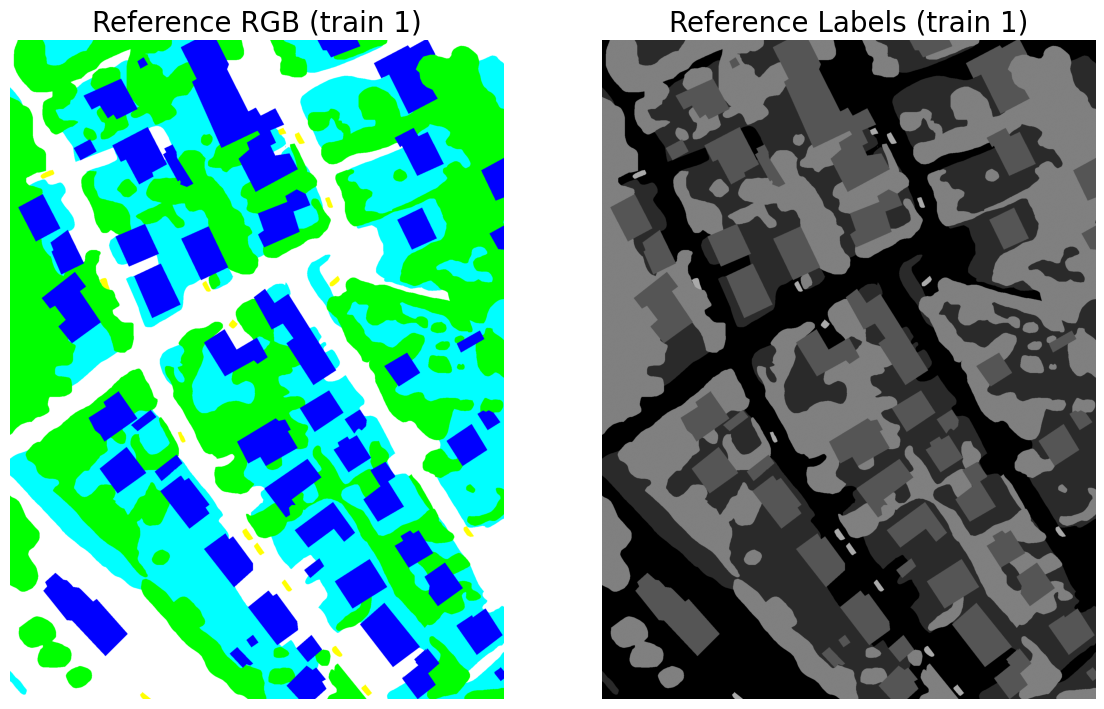

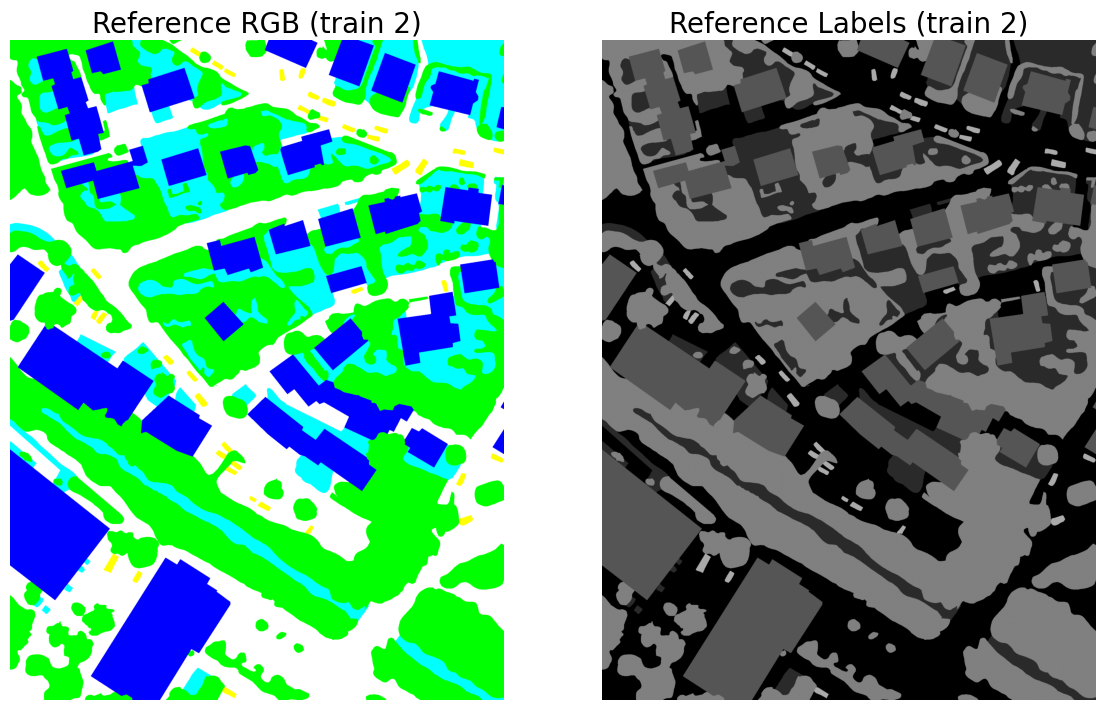

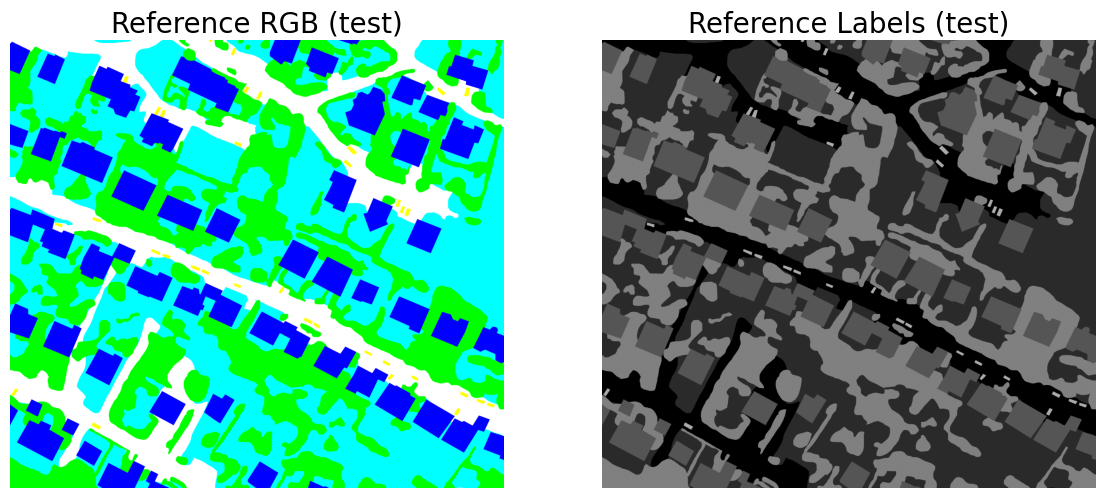

In [ ]:
# Inspecting label images (train and test)

print('\nPlotting images...')

fig1, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_train1 )
ax1.set_title('Reference RGB (train 1)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_train1, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels (train 1)', fontsize=20)
ax2.axis('off')

fig2, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_train2 )
ax1.set_title('Reference RGB (train 2)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_train2, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels (train 2)', fontsize=20)
ax2.axis('off')

fig3, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_test )
ax1.set_title('Reference RGB (test)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels (test)', fontsize=20)
ax2.axis('off')

# **5. Extracting image patches for training**

In [ ]:
# Constants and functions

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_size = 256

# patch_stride determine the position of the next patch.
# A patch_stride smaller than the spatial dimension of the patch determines an overlapping.
# 25% ​​overlap between patches.
patch_stride = patch_size - (patch_size // 4)

# channels of the image/patches to be segmented
image_channels = 4

# shape of the input to the network (training)
input_shape = (patch_size, patch_size, image_channels)

# Function: extract_patches
# -------------------------
# Extract patches from the original and reference image
#
# Input parameters:
#   image      = array containing the original image (h,w,c)
#   reference  = array containing the reference image (h,w,c)
#   patch_size = patch size (scalar). The shape of the patch is square.
#   stride     = displacement to be applied.
#   border_patches = include patches overlaping image borders
#
# Returns:
#   A, B = List containing the patches for the input image (A) and respective reference (B).
#
def extract_patches(image, reference, patch_size, stride, border_patches=False):
    print("Image dimensions:", image.shape)
    print("Reference dimensions:", reference.shape)

    patch_img = []
    patch_ref = []

    h = image.shape[0] // stride
    w = image.shape[1] // stride

    for m in range(0, h):
        for n in range(0, w):
            #print('M %d, N %d, start %d finish %d , start %d finish %d' % (m, n, m*stride , m*stride+patch_size, n*stride, n*stride+patch_size) )
            if ( (m*stride+patch_size <= image.shape[0]) and (n*stride+patch_size <= image.shape[1]) ):
                patch_img.append( image[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size,:] )
                patch_ref.append( reference[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size] )
            elif border_patches:
                border_patch_img = np.zeros((patch_size,patch_size,image_channels))
                border_patch_ref = np.zeros((patch_size,patch_size))
                if (m*stride+patch_size > image.shape[0]):
                  border_mmax = patch_size-(m*stride+patch_size-image.shape[0])
                else:
                  border_mmax = patch_size-1
                if (n*stride+patch_size > image.shape[1]):
                  border_nmax = patch_size-(n*stride+patch_size-image.shape[1])
                else:
                  border_nmax = patch_size-1

                border_patch_img[0:border_mmax,0:border_nmax,:] = image[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax,:]
                border_patch_ref[0:border_mmax,0:border_nmax] = reference[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax]
                patch_img.append( border_patch_img )
                patch_ref.append( border_patch_ref )

    return np.array(patch_img), np.array(patch_ref)


In [ ]:
# Extracting training 1 patches

x1_patches, y1_patches = extract_patches(image_train1, labels_train1, patch_size, patch_stride)

# Extracting training 1 + DSM patches

x1d_patches, y1d_patches = extract_patches(train1d, labels_train1, patch_size, patch_stride)

# Extracting training 2 patches

x2_patches, y2_patches = extract_patches(image_train2, labels_train2, patch_size, patch_stride)

# Extracting training 2 patches + DSM patches

x2d_patches, y2d_patches = extract_patches(train2d, labels_train2, patch_size, patch_stride)


# Transform y_patches, shape (N, H, W) into shape (N, H, W, C). Necessary for data agumentation.
y1_patches = np.expand_dims(y1_patches, 3)
y2_patches = np.expand_dims(y2_patches, 3)
y1d_patches = np.expand_dims(y1d_patches, 3)
y2d_patches = np.expand_dims(y2d_patches, 3)


# Combine patches from both training sets
x_patches = np.concatenate((x1_patches, x2_patches), axis=0)
y_patches = np.concatenate((y1_patches, y2_patches), axis=0)

# Combine patches from both training sets + DSM
xd_patches = np.concatenate((x1d_patches, x2d_patches), axis=0)
yd_patches = np.concatenate((y1d_patches, y2d_patches), axis=0)



print( "Number of patches: %d %s " % ( x1_patches.shape[0], x1_patches.shape[1:] ) )
print( "Number of patches: %d %s " % ( x2_patches.shape[0], x2_patches.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y1_patches.shape[0], y1_patches.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y2_patches.shape[0], y2_patches.shape[1:] ) )

Image dimensions: (2565, 1919, 3)
Reference dimensions: (2565, 1919)
Image dimensions: (2565, 1919, 4)
Reference dimensions: (2565, 1919)
Image dimensions: (2546, 1903, 3)
Reference dimensions: (2546, 1903)
Image dimensions: (2546, 1903, 4)
Reference dimensions: (2546, 1903)
Number of patches: 117 (256, 256, 3) 
Number of patches: 108 (256, 256, 3) 
Number of labeled references: 117 (256, 256, 1) 
Number of labeled references: 108 (256, 256, 1) 



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

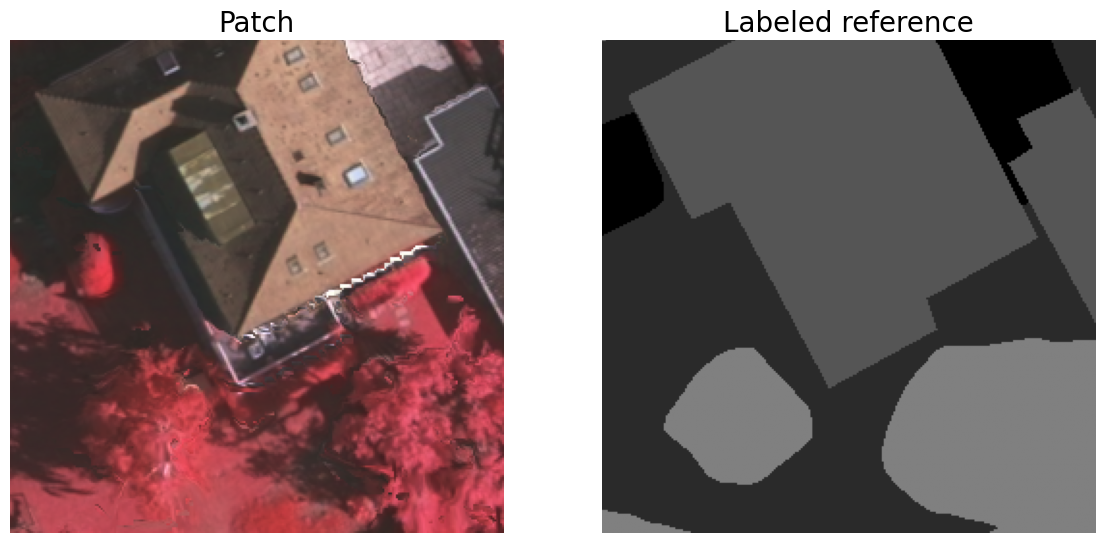

In [ ]:
# Inspecting an arbitrary image patch

image_index = 20

print('\nPlotting images...')
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))

ax1.imshow( x_patches[image_index] )
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_patches[image_index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Labeled reference', fontsize=20)
ax2.axis('off')

# **6. Separating training and validation patches**

In [ ]:
# Defining the percentage of the training set to be used as validation
valid_percent = 0.2

# Calculating the boundary (index) between training set and validation.
# The premise is always that X and Y have the same number of elements.
limit = len(x_patches) - int( len(x_patches)*valid_percent )
limitd = len(xd_patches) - int( len(xd_patches)*valid_percent )
limit1 = len(x1_patches) - int( len(x1_patches)*valid_percent )
limit2 = len(x2_patches) - int( len(x2_patches)*valid_percent )
limit1d = len(x1d_patches) - int( len(x1d_patches)*valid_percent )


# Building a list of indexes from 0 to N, where N corresponds to the number of images (patches).
indexes = [i for i in range(x_patches.shape[0])]
indexesd = [i for i in range(xd_patches.shape[0])]
indexes1 = [i for i in range(x1_patches.shape[0])]
indexes2 = [i for i in range(x2_patches.shape[0])]
indexes1d = [i for i in range(x1d_patches.shape[0])]

# Generating randomness in the list
import random
random.shuffle(indexes)
random.shuffle(indexesd)
random.shuffle(indexes1)
random.shuffle(indexes1d)
random.shuffle(indexes2)

# Indexes of the images that will be used for training
indexes_for_train = indexes[:limit]

indexes_for_traind = indexesd[:limitd]

indexes_for_train1 = indexes1[:limit1]

indexes_for_train1d = indexes1d[:limit1d]

indexes_for_train2 = indexes2[:limit2]

# ndexes of the images that will be used for validation
indexes_for_valid = indexes[limit:]
indexes_for_validd = indexesd[limitd:]
indexes_for_valid1 = indexes1[limit1:]
indexes_for_valid1d = indexes1[limit1d:]
indexes_for_valid2 = indexes2[limit2:]

# Training set
x_train = x_patches[indexes_for_train]
y_train = y_patches[indexes_for_train]

# Training set + DSM
xd_train = xd_patches[indexes_for_traind]
yd_train = yd_patches[indexes_for_traind]

# Training set 1
x1_train = x1_patches[indexes_for_train1]
y1_train = y1_patches[indexes_for_train1]

# Training set 1d
x1d_train = x1d_patches[indexes_for_train1d]
y1d_train = y1d_patches[indexes_for_train1d]

# Training set 2
x2_train = x2_patches[indexes_for_train2]
y2_train = y2_patches[indexes_for_train2]

# Validation set
x_valid = x_patches[indexes_for_valid]
y_valid = y_patches[indexes_for_valid]

# Validation set
xd_valid = xd_patches[indexes_for_validd]
yd_valid = yd_patches[indexes_for_validd]

# Validation set 1
x1_valid = x1_patches[indexes_for_valid1]
y1_valid = y1_patches[indexes_for_valid1]

# Validation set 1
x1d_valid = x1d_patches[indexes_for_valid1d]
y1d_valid = y1d_patches[indexes_for_valid1d]

# Validation set 2
x2_valid = x2_patches[indexes_for_valid2]
y2_valid = y2_patches[indexes_for_valid2]

print( "Número de imagens no conjunto de treinamento: %d " % ( len(x_train) ) )
print( "Número de imagens no conjunto de validação: %d " % ( len(x_valid) ) )
print( "Número de imagens no conjunto de treinamento 1: %d " % ( len(x1_train) ) )
print( "Número de imagens no conjunto de validação 1: %d " % ( len(x1_valid) ) )
print( "Número de imagens no conjunto de treinamento 2: %d " % ( len(x2_train) ) )
print( "Número de imagens no conjunto de validação 2: %d " % ( len(x2_valid) ) )

# Freeing up memory
x_patches = 0
y_patches = 0
xd_patches = 0
yd_patches = 0
x1_patches = 0
x2_patches = 0
y1_patches = 0
y2_patches = 0
x1d_patches = 0
y1d_patches = 0

Número de imagens no conjunto de treinamento: 180 
Número de imagens no conjunto de validação: 45 
Número de imagens no conjunto de treinamento 1: 94 
Número de imagens no conjunto de validação 1: 23 
Número de imagens no conjunto de treinamento 2: 87 
Número de imagens no conjunto de validação 2: 21 


# **7. Data augmentation**

In [ ]:
# Setting data augmentation tranformations and creating data generators
import tensorflow as tf


def augment_data(image):
    k = np.random.choice([-1, 0, 1])
    image = tf.image.rot90(image, k)
    image = tf.image.flip_left_right(image)
    image = tf.image.flip_up_down(image)

    return image

# Tranformations for image patches
datagen_args_x = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=augment_data,

        # brightness_range=[0.8,1.2], # brightness
        fill_mode='constant',
        cval=0
)

# Transformations for reference patches
datagen_args_y = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=augment_data,

        fill_mode='constant',
        cval=0
)

# Its necessary to provide the same seed and kwargs to the flow method (images and references)
seed = 1
x_datagen = ImageDataGenerator(**datagen_args_x)
y_datagen = ImageDataGenerator(**datagen_args_y)

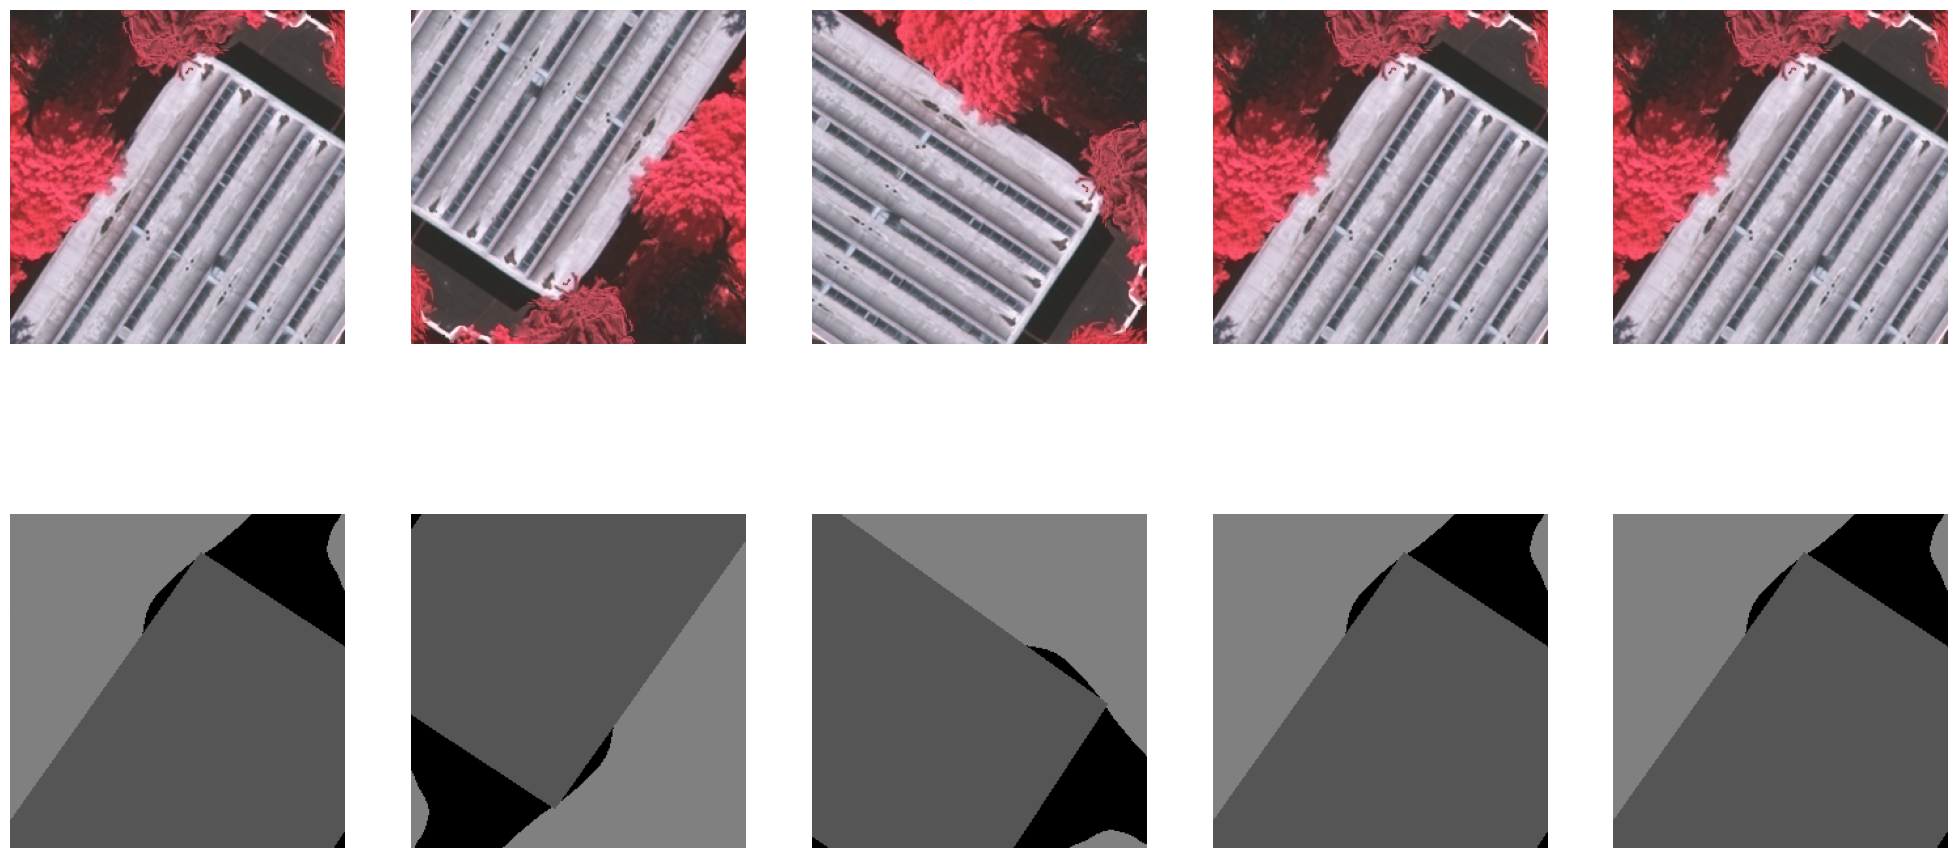

In [ ]:
# Example of Data Augmentation for an arbitrary patch

show_index = 25

x_patch = np.expand_dims( x_train[show_index], 0 )
y_patch = np.expand_dims( y_train[show_index], 0 )

x_iterator = x_datagen.flow(x_patch, seed=seed)
y_iterator = y_datagen.flow(y_patch, seed=seed)

data_iterator = next( zip( x_iterator, y_iterator ) )

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,12))

# generating transformed images
for j in range(ncols):
    data_iterator = next( zip( x_iterator, y_iterator ) )
    ax[0][j].axis('off')
    ax[0][j].imshow(data_iterator[0][0])
    ax[1][j].axis('off')
    ax[1][j].imshow(data_iterator[1][0,:,:,0], cmap='gray', vmin=0, vmax=num_classes )

# **8. Building the CNN model**

In [ ]:
# Defining the structure of the CNN
from tensorflow.keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Flatten, Conv2DTranspose, BatchNormalization

def segnet(input_shape, n_classes):

    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv7 = BatchNormalization()(conv7)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv7)

    conv8 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv8 = BatchNormalization()(conv8)
    conv9 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv8)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = BatchNormalization()(conv10)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv10)

    conv11 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv11 = BatchNormalization()(conv11)
    conv12 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv11)
    conv12 = BatchNormalization()(conv12)
    conv13 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv12)
    conv13 = BatchNormalization()(conv13)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv13)

    # Decoder
    upsample1 = UpSampling2D(size=(2, 2))(pool5)
    deconv1 = Conv2D(512, (3, 3), activation='relu', padding='same')(upsample1)
    deconv1 = BatchNormalization()(deconv1)
    deconv2 = Conv2D(512, (3, 3), activation='relu', padding='same')(deconv1)
    deconv2 = BatchNormalization()(deconv2)
    deconv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(deconv2)
    deconv3 = BatchNormalization()(deconv3)

    upsample2 = UpSampling2D(size=(2, 2))(deconv3)
    deconv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(upsample2)
    deconv4 = BatchNormalization()(deconv4)
    deconv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(deconv4)
    deconv5 = BatchNormalization()(deconv5)
    deconv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(deconv5)
    deconv6 = BatchNormalization()(deconv6)

    upsample3 = UpSampling2D(size=(2, 2))(deconv6)
    deconv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(upsample3)
    deconv7 = BatchNormalization()(deconv7)
    deconv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(deconv7)
    deconv8 = BatchNormalization()(deconv8)
    deconv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(deconv8)
    deconv9 = BatchNormalization()(deconv9)

    upsample4 = UpSampling2D(size=(2, 2))(deconv9)
    deconv10 = Conv2D(128, (3, 3), activation='relu', padding='same')(upsample4)
    deconv10 = BatchNormalization()(deconv10)
    deconv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(deconv10)
    deconv11 = BatchNormalization()(deconv11)

    upsample5 = UpSampling2D(size=(2, 2))(deconv11)
    deconv12 = Conv2D(64, (3, 3), activation='relu', padding='same')(upsample5)
    deconv12 = BatchNormalization()(deconv12)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(deconv12)

    model = Model(inputs=inputs, outputs=outputs, name='SegNet')
    return model


def unet(input_shape, n_classes):
# U-Net architecture

    input_img = Input(input_shape)
    start_neurons = 64
    # Contract stage
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_img)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)


    # Expansion stage

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    # Output segmentation

    output = Conv2D(n_classes,(1,1), activation = 'softmax')(uconv1)
    return Model(inputs = input_img, outputs = output, name='U-Net')

In [ ]:
# Building the model

model = unet(input_shape, num_classes)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# **9. Functions for training the network**

In [ ]:
# Functions for training

def set_number_of_batches(qt_train_samples, qt_valid_samples, batch_size, data_augmentation, number_samples_for_generator=6):
    if data_augmentation:
        train_batchs_qtd = qt_train_samples//number_samples_for_generator
        valid_batchs_qtd = qt_valid_samples//number_samples_for_generator
    else:
        train_batchs_qtd = qt_train_samples//batch_size
        valid_batchs_qtd = qt_valid_samples//batch_size

    return train_batchs_qtd, valid_batchs_qtd

def get_batch_samples(x, y, batch, batch_size, data_augmentation, number_samples_for_generator):
    if data_augmentation:
        x_batch = x[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]
        y_batch = y[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]

        x_iterator = x_datagen.flow(x_batch, seed=batch)
        y_iterator = y_datagen.flow(y_batch, seed=batch)

        x_batch = np.array([next(x_iterator)[0] for _ in range(batch_size)])
        y_batch = np.array([next(y_iterator)[0] for _ in range(batch_size)])
    else:
        x_batch = x[batch * batch_size : (batch + 1) * batch_size, : , : , :]
        y_batch = y[batch * batch_size : (batch + 1) * batch_size, : , : , :]

    return x_batch, y_batch

def train_unet(net, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, filepath, filename, data_augmentation=False, number_samples_for_generator=1):
    print('Start the training...')

    # calculating number of batches
    train_batchs_qtd, valid_batchs_qtd = set_number_of_batches(x_train.shape[0], x_valid.shape[0], batch_size, data_augmentation, number_samples_for_generator)

    history_train = []
    history_valid = []
    valid_loss_best_model = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        print('Start epoch ... %d ' %(epoch) )
        # shuffle train set
        x_train, y_train = shuffle(x_train , y_train, random_state = 0)

        # TRAINING
        train_loss = np.zeros((1 , 2))
        # mini batches strategy
        for  batch in range(train_batchs_qtd):
            print('Start batch ... %d ' %(batch) )
            x_train_batch, y_train_batch = get_batch_samples(x_train, y_train, batch, batch_size, data_augmentation, number_samples_for_generator)
            train_loss = train_loss + net.train_on_batch(x_train_batch, y_train_batch)

        # Estimating the loss in the training set
        train_loss = train_loss/train_batchs_qtd

        # VALIDATING
        valid_loss = np.zeros((1 , 2))
        # Evaluating the network (model) with the validation set
        for  batch in range(valid_batchs_qtd):
            x_valid_batch, y_valid_batch = get_batch_samples(x_valid, y_valid, batch, batch_size, data_augmentation, number_samples_for_generator)
            valid_loss = valid_loss + net.test_on_batch(x_valid_batch, y_valid_batch)

        # Estimating the loss in the validation set
        valid_loss = valid_loss/valid_batchs_qtd

        # Showing the results.
        print("%d [training loss: %f , Train acc.: %.2f%%][Test loss: %f , Test acc.:%.2f%%]" %(epoch , train_loss[0 , 0], 100*train_loss[0 , 1] , valid_loss[0 , 0] , 100 * valid_loss[0 , 1]))
        history_train.append( train_loss )
        history_valid.append( valid_loss )

        # Early Stopping
        if (1-(valid_loss[0 , 0]/valid_loss_best_model)) < early_stopping_delta:
            if no_improvement_count+1 >= early_stopping_epochs:
                print('Early Stopping reached')
                break
            else:
                no_improvement_count = no_improvement_count+1
        else:
            valid_loss_best_model = valid_loss[0 , 0]
            no_improvement_count = 0

            # Saving best model
            print("Saving the model...")
            net.save(filepath+filename+'.h5')

    return [ history_train, history_valid ]


# **10. Defining hyperparameters**

In [ ]:
# Defining hyperparameters for training

batch_size = 16
epochs = 150

# Fixed class weights: [Impervious surfaces, Low vegetation, Building, Tree, Car]
class_weights = [0.10, 0.10, 0.10 , 0.10, 3.00]

# Early stoping parameters
early_stopping_epochs = 30
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.01%

data_augmentation = True
number_samples_for_generator = 4

# optimizer
adam = Adam(learning_rate = 0.0001 , beta_1=0.9)

# **11. Start training**

In [ ]:
# Compile the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer=adam , metrics=['accuracy'], loss_weights=class_weights)

# Train the model
best_model_filename = 'best_CNN_model'
history = train_unet(model, xd_train, yd_train, xd_valid, yd_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
# Uncomment the line above for training with the whole dataset!!!
#history = train_unet(model, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)


A saída de streaming foi truncada nas últimas 5000 linhas.
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start batch ... 4 
Start batch ... 5 
Start batch ... 6 
Start batch ... 7 
Start batch ... 8 
Start batch ... 9 
Start batch ... 10 
Start batch ... 11 
Start batch ... 12 
Start batch ... 13 
Start batch ... 14 
Start batch ... 15 
Start batch ... 16 
Start batch ... 17 
Start batch ... 18 
Start batch ... 19 
Start batch ... 20 
Start batch ... 21 
Start batch ... 22 
Start batch ... 23 
Start batch ... 24 
Start batch ... 25 
Start batch ... 26 
Start batch ... 27 
Start batch ... 28 
Start batch ... 29 
Start batch ... 30 
Start batch ... 31 
Start batch ... 32 
Start batch ... 33 
Start batch ... 34 
Start batch ... 35 
Start batch ... 36 
Start batch ... 37 
Start batch ... 38 
Start batch ... 39 
Start batch ... 40 
Start batch ... 41 
Start batch ... 42 
Start batch ... 43 
Start batch ... 44 
24 [training loss: 0.063990 , Train acc.: 75.04%][Test loss: 0.064039 

# **12. Training History Graph**

In [ ]:
# Functions

def show_graph_loss_accuracy(history,accuracy_position):
    plt.rcParams['axes.facecolor']='white'
    plt.figure(num=1, figsize=(14,6))

    config = [ { 'title': 'model accuracy', 'ylabel': 'accuracy', 'legend_position': 'upper left', 'index_position': accuracy_position },
               { 'title': 'model loss', 'ylabel': 'loss', 'legend_position': 'upper right', 'index_position': 0 } ]

    for i in range(len(config)):

        plot_number = 120 + (i+1)
        plt.subplot(plot_number)
        plt.plot(history[0,:,0,config[i]['index_position']])
        plt.plot(history[1,:,0,config[i]['index_position']])
        plt.title(config[i]['title'])
        plt.ylabel(config[i]['ylabel'])
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc=config[i]['legend_position'])
        plt.tight_layout()

    plt.show()

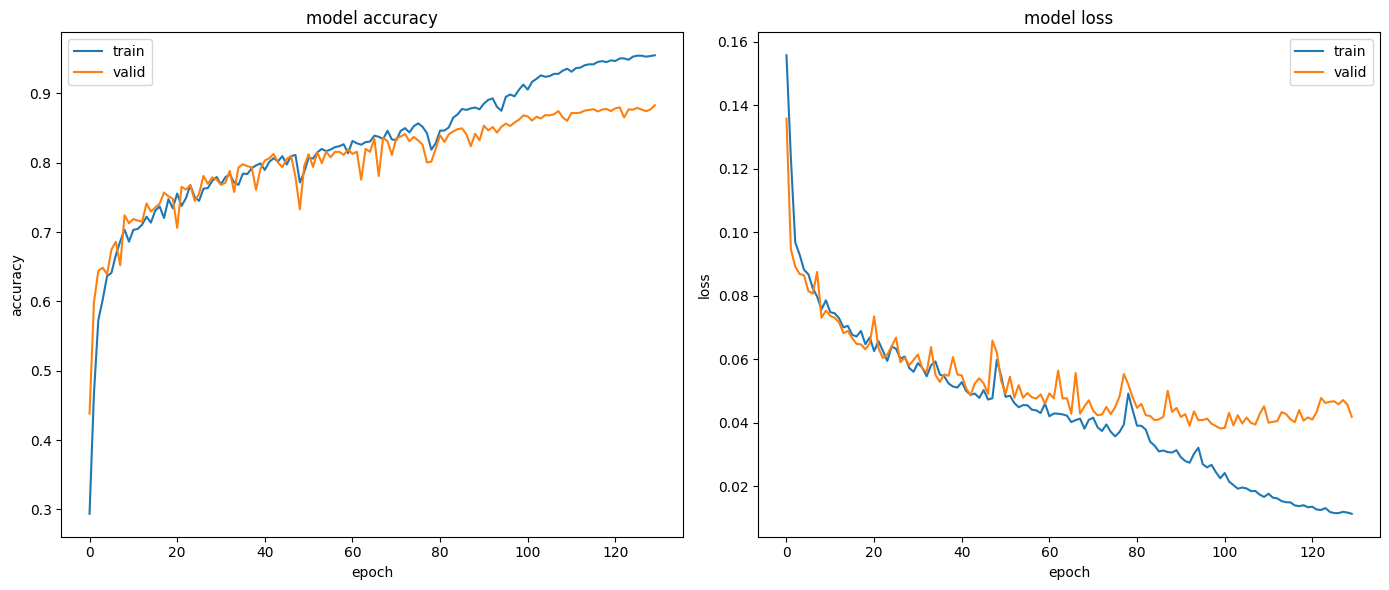

In [ ]:
# Show history

show_graph_loss_accuracy(np.asarray(history),1)

# **13. Evaluating the CNN model over training and validation data**

In [ ]:
# Functions

def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_classes = np.argmax(result, axis=-1)
    return predicted_classes

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

In [ ]:
# load the best model (.h5 file)
model = load_model(root_path + best_model_filename + '.h5', compile=False)

# Test the model over training and validation data
pred_train = Test(model, xd_train)
pred_valid = Test(model, xd_valid)

2/2 [==============================] - 7s 7s/step



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

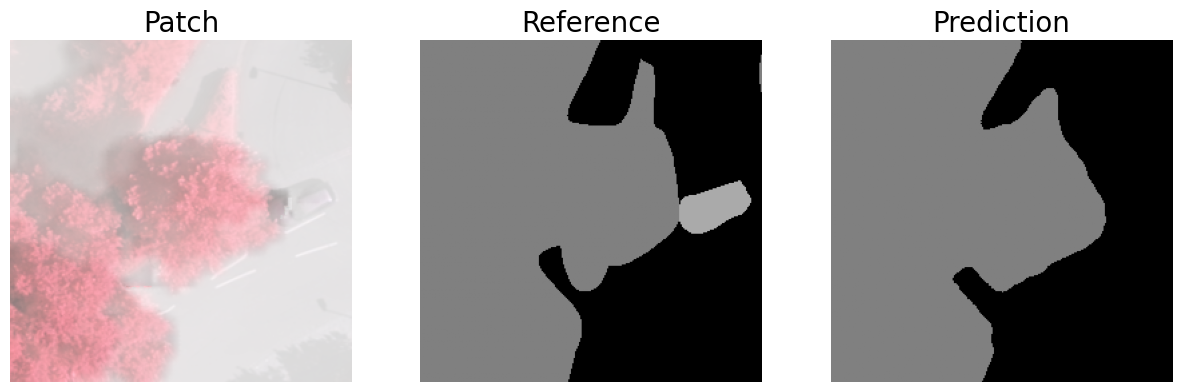

In [ ]:
# Showing the prediction for an arbitrary training patch

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(xd_train[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( yd_train[index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_train[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')

In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data

true_labels = np.reshape(yd_train, (yd_train.shape[0]* yd_train.shape[1]*yd_train.shape[2]))
predicted_labels = np.reshape(pred_train, (pred_train.shape[0]* pred_train.shape[1]*pred_train.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[2800289   50205   27483  117808    7211]
 [  45110 1877128   81897  365638      16]
 [  24974   36419 2352182   28984    1462]
 [  63002  116018   34674 3708591     177]
 [  29941      24      64    1428   25755]]

Metrics
Accuracy:  91.2470923529731
F1score:  [93.87001551 84.3732098  95.22385286 91.06523079 56.0909477 ]
Recall:  [93.24984116 79.21076518 96.24229906 94.54753163 45.0167797 ]
Precision:  [94.49849425 90.25547723 94.22673557 87.83033259 74.39126542]


In [ ]:
# Showing the confusion matrix and accuracy metrics for the validation data

true_labels = np.reshape(yd_valid, (yd_valid.shape[0]* yd_valid.shape[1]*yd_valid.shape[2]))
predicted_labels = np.reshape(pred_valid, (pred_valid.shape[0]* pred_valid.shape[1]*pred_valid.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[ 635056   28624   17106   43222    1709]
 [  18323  331844   25724  129626     185]
 [  12457    9563  501513    7910     170]
 [  31531   59080    7821 1071703       0]
 [   9255       1     488      70    6139]]

Metrics
Accuracy:  86.33948432074654
F1score:  [88.67398011 70.99679722 92.50745897 88.4730293  50.82795165]
Recall:  [87.50738924 65.62046423 94.33798647 91.58797916 38.48179026]
Precision:  [89.87209569 77.33272432 90.74661812 85.56299205 74.83847373]


In [ ]:
# Freeing up memory

xd_train = 0
yd_train = 0
xd_valid = 0
yd_valid = 0
pred_train = 0
pred_valid = 0
true_labels = 0
predicted_labels = 0

# **14. Inference (testing the CNN model)**

In [ ]:
# load the best model (.h5 file)
best_model_filename = 'best_CNN_model'
model = load_model(root_path + best_model_filename + '.h5', compile=False)

In [ ]:
# Constants

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_test_size = patch_size
patch_test_stride = 128


In [ ]:
# Extracting test patches

x_patches_test, y_patches_test = extract_patches(testd, labels_test, patch_test_size, patch_test_stride, True)

print( "Number of patches: %d %s " % ( x_patches_test.shape[0], x_patches_test.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y_patches_test.shape[0], y_patches_test.shape[1:] ) )

Image dimensions: (2558, 2818, 4)
Reference dimensions: (2558, 2818)
Number of patches: 418 (256, 256, 4) 
Number of labeled references: 418 (256, 256) 


# **15. Prediction over test patches**

In [ ]:
# Test the model over test patches

pred_test_patches = Test(model, x_patches_test)
print(pred_test_patches.shape)

14/14 [==============================] - 9s 620ms/step
(418, 256, 256)



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

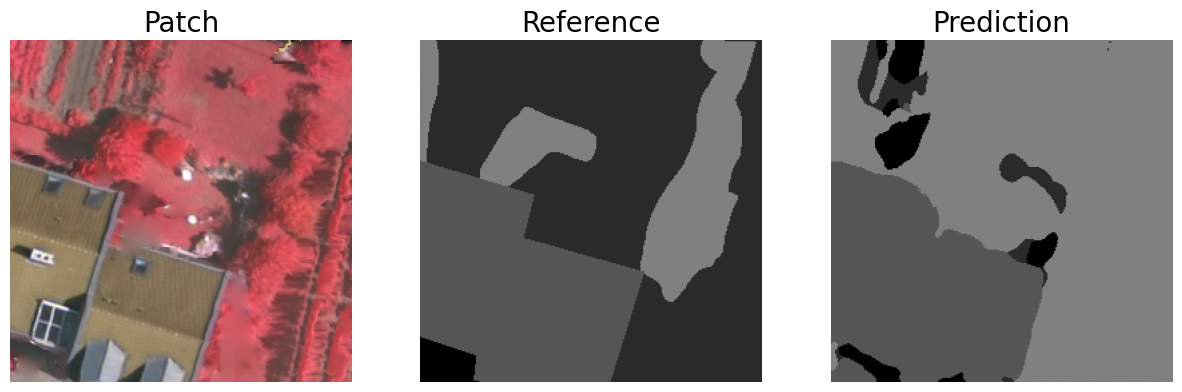

In [ ]:
# Showing prediction result for an arbitrary test patch

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_patches_test[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_patches_test[index], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_patches[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')


In [ ]:
# Showing the confusion matrix and accuracy metrics for the test data (patches)

true_labels = np.reshape(y_patches_test, (y_patches_test.shape[0]* y_patches_test.shape[1]*y_patches_test.shape[2]))
predicted_labels = np.reshape(pred_test_patches, (pred_test_patches.shape[0]* pred_test_patches.shape[1]*pred_test_patches.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[3694383  185128  297121  790583   29553]
 [ 939690 2785992 1023991 4710455   10540]
 [ 294349   64830 4436285   73887    2950]
 [ 242609  304603   77892 7324246     153]
 [  54385    1250   15088    2101   31984]]

Metrics
Accuracy:  66.70386939527886
F1score:  [72.28167679 43.48875404 82.74584017 70.253945   35.54014712]
Recall:  [73.93545188 29.41705907 91.05112759 92.13464037 30.51675445]
Precision:  [70.70026578 83.36793043 75.82904486 56.77150284 42.54322958]


# **16. Mosaic of the test patches predictions**

In [ ]:
# Assembling mosaic of the test patches predictions

pred_test_mosaic = np.zeros(labels_test.shape)
patch_test_overlap = patch_test_stride/patch_test_size

# Image positions
x = y = 0
xmax, ymax = labels_test.shape

# Patch positions
pi = patch_test_size//2 - int(patch_test_size*patch_test_overlap**2)
pf = patch_test_size//2 + int(patch_test_size*patch_test_overlap**2)

for patch in pred_test_patches:
  if y==0: ypi = 0
  else: ypi = pi
  if y+pf+patch_test_stride>ymax: ypf = ymax-y-2
  else: ypf = pf
  if x==0: xpi = 0
  else: xpi = pi
  if x+pf+patch_test_stride>xmax: xpf = xmax-x
  else: xpf = pf

  pred_test_mosaic[x+xpi:x+xpf,y+ypi:y+ypf] = patch[xpi:xpf,ypi:ypf]

  y += patch_test_stride
  if y+patch_test_stride >= ymax:
    x += patch_test_stride
    y = 0



Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

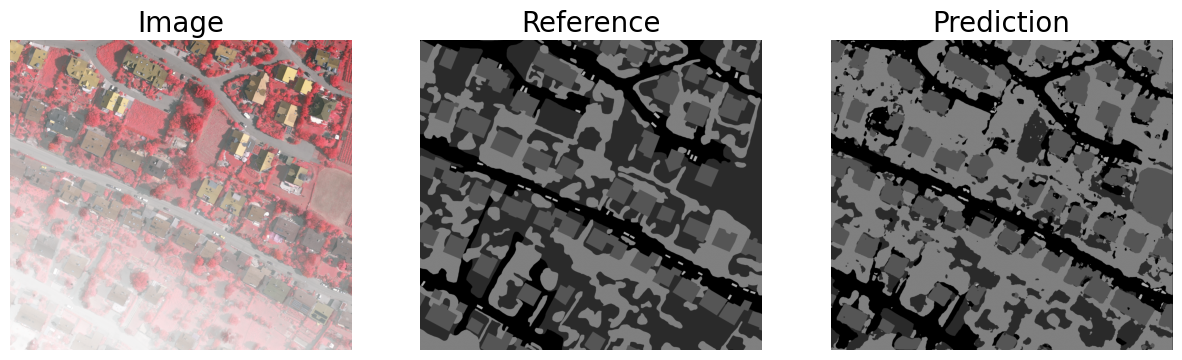

In [ ]:
# Showing prediction results mosaic

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow( testd )
ax1.set_title('Image', fontsize=20)
ax1.axis('off')

ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_mosaic, cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')

In [ ]:
# Showing the confusion matrix and accuracy metrics for the prediction results mosaic

true_labels = np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1]))
predicted_labels = np.reshape(pred_test_mosaic, (pred_test_mosaic.shape[0]*pred_test_mosaic.shape[1]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[ 981762   47043   61145   86747    8527]
 [ 278322  787338  266201 1213708    3535]
 [  80561   18308 1183955   18995     949]
 [  75355  109167   21977 1937783      24]
 [  14152     249    3258     524    8859]]

Metrics
Accuracy:  67.97163160315874
F1score:  [75.07616496 44.84711676 83.39755095 71.74233251 36.20647376]
Recall:  [82.83345595 30.88685279 90.87995714 90.36877199 32.76015088]
Precision:  [68.64738853 81.83493486 77.05351518 59.48212221 40.46314059]
